In [11]:
from typing import cast

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import callbacks, layers, models
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [12]:
tf.random.set_seed(123)

wordlist = set(pd.read_csv("input_data/words.csv", encoding="UTF-8")["words"])
mails = pd.read_csv("input_data/enron_spam_data.csv")
mails.drop(labels=["Message ID", "Date", "Subject"], axis=1, inplace=True)
mails.dropna(subset=["Message"], inplace=True)
mails.rename(
    columns={"Message": "message", "Spam/Ham": "spam"},
    inplace=True,
)
mails["spam"] = mails["spam"].map(lambda spam_ham: True if spam_ham == "spam" else False)

mails_split = train_test_split(mails, test_size=0.2, random_state=123, shuffle=True)
train_data, test_data = cast(tuple[pd.DataFrame, pd.DataFrame], mails_split)
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

nltk.download("stopwords")
nltk.download("punkt_tab")
stop_words = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lateridiot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
def clean_message(text: str) -> str:
    text = text.lower()
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    filtered = [
        stemmer.stem(w)
        for w in tokens
        if w.isalpha() and w not in stop_words and w in wordlist
    ]
    return " ".join(filtered)


train_data["clean"] = train_data["message"].apply(clean_message)
test_data["clean"] = test_data["message"].apply(clean_message)
train_data = train_data[train_data["clean"].str.len() > 0].reset_index(drop=True)
test_data = test_data[test_data["clean"].str.len() > 0].reset_index(drop=True)


In [15]:
max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["clean"])

X_train_seq = tokenizer.texts_to_sequences(train_data["clean"])
X_test_seq = tokenizer.texts_to_sequences(test_data["clean"])

X_train = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

y_train = train_data["spam"].astype(int).to_numpy()
y_test = test_data["spam"].astype(int).to_numpy()


In [29]:
model = models.Sequential(
    [
        layers.Embedding(max_words, 128),
        layers.GlobalAveragePooling1D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
early_stop = callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose="auto",
)


Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7492 - loss: 0.4832 - val_accuracy: 0.8034 - val_loss: 0.3778
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9247 - loss: 0.1912 - val_accuracy: 0.9463 - val_loss: 0.1414
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9407 - loss: 0.1527 - val_accuracy: 0.9467 - val_loss: 0.1280
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9474 - loss: 0.1348 - val_accuracy: 0.9569 - val_loss: 0.1060
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9560 - loss: 0.1184 - val_accuracy: 0.9629 - val_loss: 0.0936
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9634 - loss: 0.0947 - val_accuracy: 0.9637 - val_loss: 0.0901
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9642 - loss: 0.0885 - val_accuracy: 0.9664 - val_loss: 0.0804
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9715 - loss: 0.0744 - val_accuracy: 0

In [30]:
probs = model.predict(X_test).ravel()
predictions = probs >= 0.5

print(classification_report(y_test, predictions, target_names=["Ham", "Spam"], digits=4))


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         Ham     0.9832    0.9609    0.9719      3171
        Spam     0.9646    0.9849    0.9746      3433

    accuracy                         0.9733      6604
   macro avg     0.9739    0.9729    0.9733      6604
weighted avg     0.9736    0.9733    0.9733      6604



True Positive: 3381
False Negative: 52
True Negative: 3047
False Positive: 124


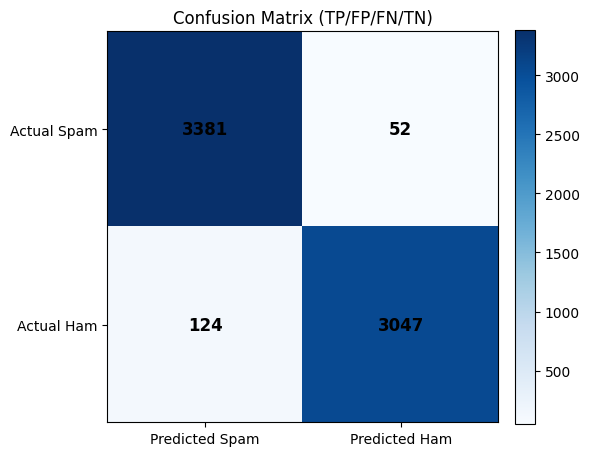

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0, 1]).ravel()

print(f"True Positive: {tp}")
print(f"False Negative: {fn}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")

fig, ax = plt.subplots(figsize=(6, 6))
matrix = [[tp, fn], [fp, tn]]
im = ax.imshow(matrix, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Predicted Spam", "Predicted Ham"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Actual Spam", "Actual Ham"])

for (i, j), value in [((0, 0), tp), ((0, 1), fn), ((1, 0), fp), ((1, 1), tn)]:
    ax.text(j, i, f"{value}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

ax.set_title("Confusion Matrix (TP/FP/FN/TN)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
